### Import Appropriate Libraries 

In [1]:
## Thomas Burt-Gray 
# Machine Learning Course Work 2023

from hmmlearn import hmm  
from sklearn.model_selection import train_test_split
import os
import pandas as pd  # use pandas to load data from CSV files
import numpy as np
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import confusion_matrix, accuracy_score
import time 


### Load in Data set 

In [2]:


data_path = "activity_recognition_dataset/S1_Dataset"

files = os.listdir(data_path)
print(files)

['d1p01M', 'd1p02M', 'd1p03M', 'd1p04M', 'd1p05M', 'd1p06M', 'd1p07M', 'd1p08F', 'd1p09F', 'd1p10F', 'd1p11F', 'd1p12F', 'd1p13F', 'd1p14F', 'd1p15F', 'd1p16F', 'd1p17F', 'd1p18F', 'd1p19F', 'd1p20F', 'd1p21F', 'd1p22F', 'd1p23F', 'd1p24F', 'd1p25F', 'd1p26F', 'd1p27F', 'd1p28F', 'd1p29F', 'd1p30F', 'd1p31F', 'd1p32F', 'd1p33F', 'd1p34F', 'd1p35F', 'd1p36M', 'd1p37M', 'd1p38M', 'd1p39M', 'd1p40M', 'd1p41M', 'd1p42M', 'd1p43M', 'd1p44M', 'd1p45M', 'd1p46M', 'd1p47M', 'd1p48M', 'd1p49F', 'd1p50F', 'd1p51F', 'd1p52F', 'd1p53F', 'd1p54F', 'd1p55F', 'd1p56F', 'd1p57F', 'd1p58F', 'd1p59F', 'd1p60F', 'README.txt']


In [3]:


combined_data = []

for file in files:
    
    if file == "README.txt":
        continue
    
    try:
        # load a single sequence from the file
        seq_dataframe = pd.read_csv(os.path.join(data_path, file), header=None, names=["time", "frontal acc", "vertical acc", "lateral acc", "antenna ID", "RSSI", "phase", "frequency", "label"])
        
        # put the ID of the sequence into the dataframe as an extra column
        seq_dataframe['seqID'] = file  # use filename as ID
                
        combined_data.append(seq_dataframe)  # put the data frame into a list
    except:
        print(f"Could not load file {file}. Skipping.")

In [4]:
# the pandas dataframe stores data in a table with headers
input_cols = ["frontal acc", "vertical acc", "lateral acc", "RSSI", "phase", "frequency"]  # column headers for the input features
output_col = "label"  # column header for the output label

# get the relevant columns from the pandas dataframes and convert to numpy arrays
X_by_seq = []  # store a list of numpy arrays containing the input features for each sequence
y_by_seq = []  # store a list of 1-D numpy arrays containing the target activity labels for each sequence

for seq_table in combined_data:
    X_by_seq.append(seq_table[input_cols].values)
    y_by_seq.append(seq_table[output_col].values - 1)    # subtract one from the label so that labels start from 0
    
n_states = np.unique(np.concatenate(y_by_seq)).size  # how many classes/states are there?



In [5]:


# create train/test split. Sequences are kept complete.
X_by_seq_tr, X_by_seq_test, y_by_seq_tr, y_by_seq_test = train_test_split(X_by_seq, y_by_seq, test_size=0.2, random_state=21)  

In [6]:
# Record which observations occur given each state (activity label)
X_given_y = [[] for _ in range(n_states)]  # empty list where we will record the observations that occur given each activity label

for s, X_seq in enumerate(X_by_seq_tr):
    for i in range(X_seq.shape[0]):
        state_i = y_by_seq_tr[s][i]
        X_given_y[state_i].append(X_seq[i, :][None, :])

In [7]:
# We recommend using this class if builing an HMM

# Record the mean feature values for observations in each state
means = np.zeros((n_states, len(input_cols)))

# Record the variance of feature values for observations in each state
diagonal_covars = np.zeros((n_states, len(input_cols)))

for state in range(n_states):
    means[state] = np.mean(X_given_y[state], axis=0)
    diagonal_covars[state, :] = np.var(X_given_y[state], axis=0)

In [8]:
X_tr = np.concatenate(X_by_seq_tr, axis=0)  # combine features into one matrix -- use this as input features for training a classifier
y_tr = np.concatenate(y_by_seq_tr)  # combine target labels into one list -- use this as target labels for training a classifier
X_test = np.concatenate(X_by_seq_test, axis=0)  # combine features into one matrix -- use this as input features for testing a classifier
y_test = np.concatenate(y_by_seq_test)  # combine target labels into one list -- use this as target labels for evaluating a classifier

# PART 2
### Task 1
#### Part A - Train a neural network classifier and plot training and validation learning curves. Interpret and discuss your plots, considering over/underfitting.

In [9]:
X_train, X_val_test, y_train, y_val_test = train_test_split(X_tr, y_tr, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

#X_train, X_test, y_train, y_test = train_test_split(X_tr, y_tr, test_size=0.3, random_state=42)


In [11]:
clf = MLPClassifier(hidden_layer_sizes=(64,), 
                    activation='relu', 
                    solver='adam', 
                    learning_rate_init=0.001, 
                    alpha=0, 
                    max_iter=1000, 
                    n_iter_no_change=10)  



In [12]:

param_grid = {
    'learning_rate_init': [0.001, 0.002, 0.003, 0.004, 0.005],
    'alpha': [0.1, 0.12, 0.14, 0.16, 0.18, 0.2]
}
param_grid = {
    'learning_rate_init': [0.0001, 0.001, 0.01, 0.1, 1],
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1],
    'hidden_layer_sizes': [10, 50, 100, 500]
}
grid_search = GridSearchCV(clf, param_grid, 
                           cv=3, verbose=2,refit=True, n_jobs = -1)

start = time.time()
grid_search.fit(X_train, y_train)
end = time.time()
difference = end-start
print("Time taken to search (s): ", difference)
best_params = grid_search.best_params_
print("Best Parameters:", best_params)
results = pd.DataFrame(grid_search.cv_results_)
results.to_csv('grid_search_results.csv', index=False)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Time taken to search (s):  272.3861708641052
Best Parameters: {'alpha': 0.001, 'hidden_layer_sizes': 500, 'learning_rate_init': 0.0001}


In [13]:

start = time.time()
tuned_clf = MLPClassifier(hidden_layer_sizes=best_params['hidden_layer_sizes'],
                          activation='relu',
                          solver='adam',
                          max_iter=1000,
                          n_iter_no_change=10,
                          learning_rate_init=best_params['learning_rate_init'], 
                          alpha=best_params['alpha'])
end = time.time()
dist = end-start 
print(f"time taken to train MLP = {dist}")



time taken to train MLP = 0.0


In [23]:
from sklearn.exceptions import ConvergenceWarning
import warnings
tuned_clf.set_params(max_iter=1, warm_start=True)
#tuned_clf.set_params(warm_start=True)
training_losses = []
validation_losses = []

warnings.filterwarnings("ignore", category=ConvergenceWarning)

for _ in range(1, 1000): # Adjust the number of epochs
    tuned_clf.fit(X_train, y_train)
    training_losses.append(tuned_clf.loss_)
    tuned_clf.loss_curve_ = []
    tuned_clf.partial_fit(X_val, y_val)
    validation_losses.append(tuned_clf.loss_curve_[-1])



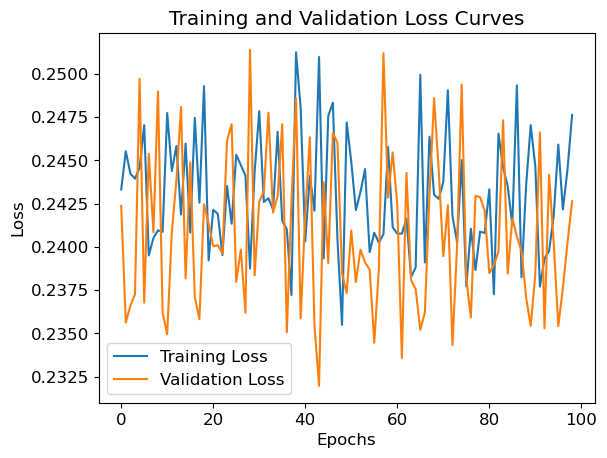

Training Accuracy: 0.9038579678093132
Test Accuracy: 0.8973770961731403


In [24]:
plt.rcParams.update({'font.size': 12})

#Plot the training and validation loss curves
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss', )
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()

# Evaluate the model
print("Training Accuracy:", tuned_clf.score(X_train, y_train))
print("Test Accuracy:", tuned_clf.score(X_test, y_test))

plt.show()

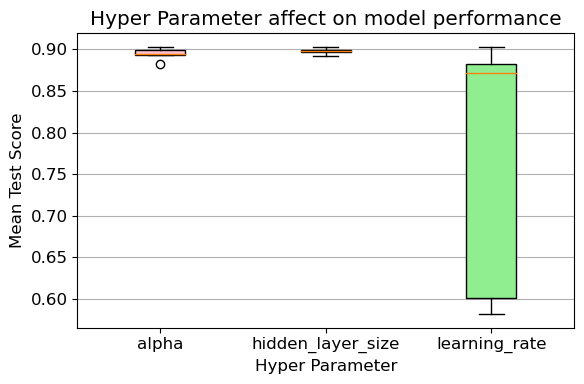

In [25]:


# Load grid search results from CSV
best = {
    'alpha': 0.0001, 
    'hidden_layer_sizes': 100, 
    'learning_rate_init': 0.001
}
grid_results = pd.read_csv("grid_search_results.csv")
alphas = grid_results[(grid_results['param_hidden_layer_sizes'] == best_params['hidden_layer_sizes']) & 
          (grid_results['param_learning_rate_init'] == best_params['learning_rate_init'])] 

h_layers = grid_results[(grid_results['param_alpha'] == best_params['alpha']) & 
          (grid_results['param_learning_rate_init'] == best_params['learning_rate_init'])] 

learning_rate = grid_results[(grid_results['param_hidden_layer_sizes'] == best_params['hidden_layer_sizes']) & 
          (grid_results['param_alpha'] == best_params['alpha'])] 

data = []

hyperparameters = ['param_alpha', 'param_hidden_layer_sizes', 'param_learning_rate_init']

data.append(alphas['mean_test_score'])
data.append(h_layers['mean_test_score'])
data.append(learning_rate['mean_test_score'])

fig, ax = plt.subplots(figsize=(6, 4))

# Create box plots for base model errors
bplot = ax.boxplot(data, patch_artist=True, labels=["alpha", "hidden_layer_size", "learning_rate"])

# Fill box plots with color
colors = ['pink', 'lightblue', 'lightgreen']
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

# Add horizontal grid lines
ax.yaxis.grid(True)
ax.set_xlabel('Hyper Parameter')
ax.set_ylabel('Mean Test Score')
ax.set_title('Hyper Parameter affect on model performance')

plt.tight_layout()
plt.show()


### Task 2
#### Part a - Train an ensemble of decision trees, and briefly describe how your ensemble improves performance over a single model. (2 marks)

In [26]:
num_models = 30
sample_size = 5000 
np.random.seed(0)

def create_ensemble(X_tr, num_models, max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features=None):
    weights = np.ones(X_tr.shape[0])/X_tr.shape[0]
    alphas = []
    all_models = []
    for m in range(num_models):
        index = np.random.choice(X_tr.shape[0], sample_size, p=weights)
        X_train_sample = X_tr[index]
        y_train_sample = y_tr[index]
        
        model = DecisionTreeClassifier(max_depth=max_depth, min_samples_split = min_samples_split, min_samples_leaf=min_samples_leaf, max_features=max_features)
        model.fit(X_train_sample, y_train_sample, sample_weight=weights[index])
        
        pred = model.predict(X_tr)
        incorrect = (pred != y_tr)
        weighted_error = np.sum(weights[incorrect])/np.sum(weights)
        
        alpha = np.log((1 - weighted_error) / (weighted_error + 1e-10)) / np.log(len(np.unique(y_tr)))
        alphas.append(alpha)
        
        weights *= np.exp(alpha * incorrect)
        weights /= np.sum(weights)
        
        all_models.append(model)
    return all_models, alphas 

In [27]:
def boosting_predict(test_data, all_models, alphas):
    combined_predictions = np.zeros((test_data.shape[0], len(np.unique(y_tr))))
    
    for idx, model in enumerate(all_models):
        preds = model.predict_proba(test_data) * alphas[idx]
        combined_predictions += preds
        
    final_predictions = np.argmax(combined_predictions, axis=1)
    return final_predictions
 ## return combined predictions to show the prediction of each model 

In [28]:

nums = [5,10,20,50]
#depths = [1,2,5,10,50]
bm_errors = []
esm_errors = []
for idx, num in enumerate(nums):
    start = time.time()
    all_models, alphas = create_ensemble(X_tr, num)
    end = time.time()
    difference = end-start
    print("Time taken to craete ensemble (s): ", difference)
    prediction = boosting_predict(X_test, all_models, alphas)
    accuracy = np.mean(prediction == y_test)
    print(f"Test set accuracy {num} models: {accuracy}")

    base_model_errors = []
    ensemble_error = 1-accuracy
    
    for model in all_models:
        y_pred = model.predict(X_test)
        error = 1 - accuracy_score(y_test, y_pred)
        base_model_errors.append(error)
    bm_errors.append(base_model_errors)
    esm_errors.append(ensemble_error)
 

Time taken to craete ensemble (s):  0.1491396427154541
Test set accuracy 5 models: 0.9843772395012182
Time taken to craete ensemble (s):  0.3003356456756592
Test set accuracy 10 models: 0.9989967034542067
Time taken to craete ensemble (s):  0.6164658069610596
Test set accuracy 20 models: 0.9995700157660886
Time taken to craete ensemble (s):  1.29038405418396
Test set accuracy 50 models: 0.9998566719220295


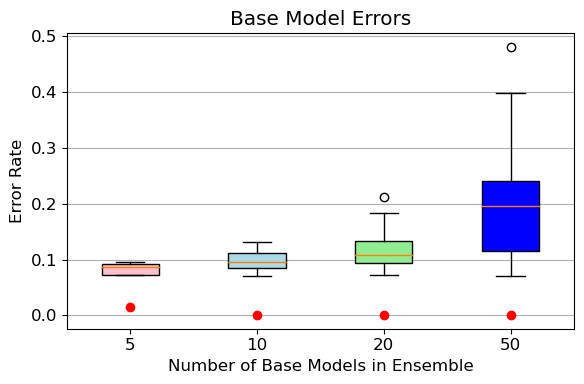

In [29]:
## Plotting results

fig, ax = plt.subplots(figsize=(6, 4))

# Create box plots for base model errors
bplot = ax.boxplot(bm_errors, patch_artist=True, labels=nums)

# Fill box plots with color
colors = ['pink', 'lightblue', 'lightgreen', 'blue', 'green']
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

# Add horizontal grid lines
ax.yaxis.grid(True)
ax.set_xlabel('Number of Base Models in Ensemble')
ax.set_ylabel('Error Rate')
ax.set_title('Base Model Errors')

# Add individual points for ensemble errors
x_coords = range(1, len(nums) + 1)
y_coords = esm_errors
ax.plot(x_coords, y_coords, color='red', marker='o', linestyle='None', label = "Ensemble Error")

plt.tight_layout()
plt.show()

In [32]:
## HYPER PARAM EXPLORING


hyperparameters = ['max_depth', 'min_samples_split', 'min_samples_leaf', 'max_features']
hyperparameter_values = {
    'max_depth': [3, 5, 7, 9],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 3, 4],
    'max_features': [None, 'sqrt', 'log2']
}

data = []
for param in hyperparameters:
    param_data = []
    for i in range(4):
        if param == 'max_depth':
            all_models, alphas = create_ensemble(X_tr, num, max_depth=hyperparameter_values[param][i])
        if param =='min_samples_split':
            all_models, alphas = create_ensemble(X_tr, num, min_samples_split=hyperparameter_values[param][i])
        if param == 'min_samples_leaf':
            all_models, alphas = create_ensemble(X_tr, num, min_samples_leaf=hyperparameter_values[param][i])
        if param == 'max_features':
            if i >= 3:
                continue
            all_models, alphas = create_ensemble(X_tr, num, max_features=hyperparameter_values[param][i])
        
        prediction = boosting_predict(X_test, all_models, alphas)
        accuracy = np.mean(prediction == y_test)
        print(f"Test set accuracy parameter{param}- {hyperparameter_values[param][i]}: {accuracy}")
        param_data.append(accuracy)
    data.append(param_data)


Test set accuracy parametermax_depth- 3: 0.8833309445320339
Test set accuracy parametermax_depth- 5: 0.9081267020209259
Test set accuracy parametermax_depth- 7: 0.9246094309875305
Test set accuracy parametermax_depth- 9: 0.9700444317041709
Test set accuracy parametermin_samples_split- 2: 0.9995700157660886
Test set accuracy parametermin_samples_split- 5: 0.9997133438440591
Test set accuracy parametermin_samples_split- 10: 1.0
Test set accuracy parametermin_samples_split- 15: 1.0
Test set accuracy parametermin_samples_leaf- 1: 0.9998566719220295
Test set accuracy parametermin_samples_leaf- 2: 1.0
Test set accuracy parametermin_samples_leaf- 3: 0.9997133438440591
Test set accuracy parametermin_samples_leaf- 4: 1.0
Test set accuracy parametermax_features- None: 0.9995700157660886
Test set accuracy parametermax_features- sqrt: 0.9998566719220295
Test set accuracy parametermax_features- log2: 0.9997133438440591


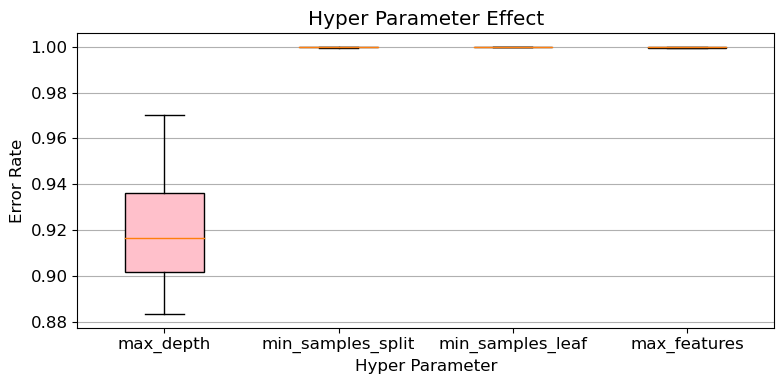

In [33]:
fig, ax = plt.subplots(figsize=(8, 4))
# Create box plots for base model errors
bplot = ax.boxplot(data, patch_artist=True, labels=hyperparameters)

# Fill box plots with color
colors = ['pink', 'lightblue', 'lightgreen', 'blue', 'green']
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

# Add horizontal grid lines
ax.yaxis.grid(True)
ax.set_xlabel('Hyper Parameter')
ax.set_ylabel('Error Rate')
ax.set_title('Hyper Parameter Effect')


plt.tight_layout()
plt.show()

### Task 3
#### Creating HMM for sequence labelling


In [36]:

X_train_flat = np.concatenate(X_by_seq_tr)
seq_lengths = [len(seq) for seq in X_by_seq_tr]
total_length = sum(seq_lengths)
start = time.time()
gausHmm = hmm.GaussianHMM(n_components=n_states, covariance_type='diag')
gausHmm.fit(X_train_flat, seq_lengths)
gausHmm.means_ = means
gausHmm.covars_ = diagonal_covars
end = time.time()
dist = end-start
print(f"time taken to train HMM {dist}")
  


time taken to train HMM 0.7092196941375732


In [37]:
import seaborn as sns
X_test_flat = np.concatenate(X_by_seq_test)
y_test_flat = np.concatenate(y_by_seq_test)
lengths_test = [len(seq) for seq in X_by_seq_test]

predicted_states = gausHmm.predict(X_test_flat, lengths=lengths_test)
conf_matrix = confusion_matrix(y_test_flat, predicted_states, normalize='true')
accuracy = accuracy_score(y_test_flat, predicted_states)
print("Accuracy:", accuracy)
transition_matrix = gausHmm.transmat_
print(means.shape, diagonal_covars.shape)
print(means)
# plt.figure(figsize=(12, 6))
# sns.heatmap(conf_matrix, annot=True, fmt='.1%', cmap='coolwarm')  # 'fmt' is the string format code
# plt.title('Confusion Matrix')
# plt.xlabel('Predicted Labels')
# plt.ylabel('True Labels')
# plt.figure(figsize=(8, 6))
# sns.heatmap(transition_matrix, annot=True, fmt='.1%', cmap='coolwarm')  # 'fmt' is the string format code
# plt.title('Transition Matrix')
# plt.xlabel('New State')
# plt.ylabel('Current State')
# plt.show()

Accuracy: 0.9075841285786037
(4, 6) (4, 6)
[[ 3.57468029e-01  9.33799900e-01  5.73068933e-02 -5.89921417e+01
   3.15720544e+00  9.22742689e+02]
 [ 5.51372453e-01  8.66495244e-01  6.65145311e-02 -5.81649136e+01
   3.48891218e+00  9.22653706e+02]
 [ 1.09237509e+00  8.96515496e-04 -2.67407824e-02 -5.84239865e+01
   3.32236377e+00  9.22799698e+02]
 [ 2.23426814e-01  9.65194724e-01  2.29370871e-02 -5.41901012e+01
   3.14808656e+00  9.22885264e+02]]


###### Part 3
#### PCA implementation on breast cancer dataset 

In [38]:
data = pd.read_csv("wdbc.data")
y = data.iloc[:,1].to_numpy()
X = data.iloc[:, 2:].to_numpy()

In [39]:
k = 2
pca_model = PCA(n_components=k)
pcs = pca_model.fit_transform(X)



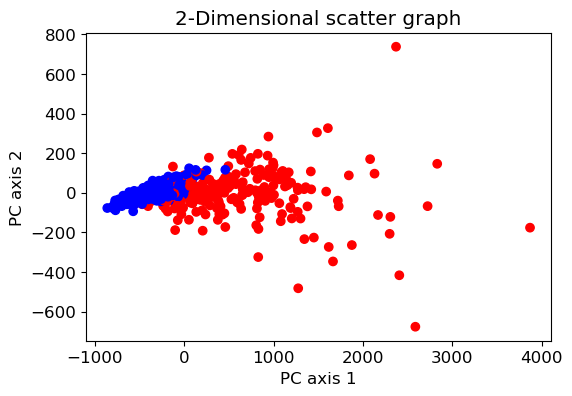

In [40]:
colours = []
for idx, label in enumerate(y):
    if label == "B":
        colours.append("Blue")
    else:
        colours.append("Red")
        
plt.figure(figsize=(6,4))
plt.scatter(pcs[:,0], pcs[:,1], c=colours)
plt.ylabel("PC axis 2")
plt.xlabel("PC axis 1")
plt.title("2-Dimensional scatter graph")
plt.show()

(568, 2)


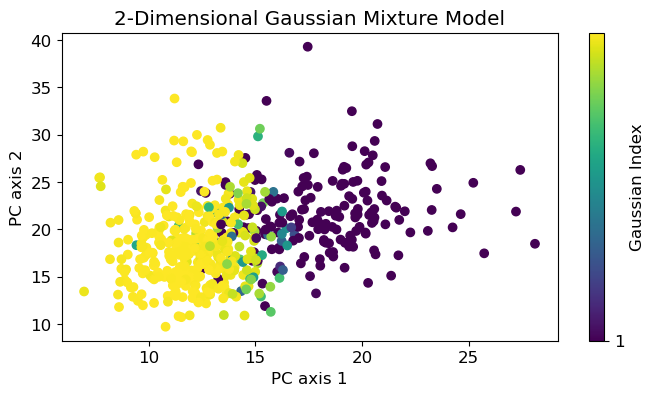

[442188.20291909   7169.67274   ]
[0.98229806 0.01592705]


In [41]:

gmm = GaussianMixture(n_components=k, max_iter=100, warm_start=False, init_params='random', tol=1e-8)
gmm.fit(pcs)
print(pcs.shape)
plt.figure(figsize=(8, 4))

plt.scatter(X[:, 0], X[:, 1], c=gmm.predict_proba(pcs)[:,0], cmap="viridis")


cbar = plt.colorbar(ticks=[0,1])
cbar.ax.set_yticklabels([1, 2])
cbar.set_label('Gaussian Index')

plt.title('2-Dimensional Gaussian Mixture Model')
plt.xlabel('PC axis 1')
plt.ylabel('PC axis 2')
plt.show()

print(pca_model.explained_variance_)
print(pca_model.explained_variance_ratio_)

# PART 4
#### Classification with SVMs

In [42]:


from sklearn.svm import SVC
X_train, y_train = X[:450], y[:450]
X_test, y_test = X[450:], y[450:]

X_tr_2dim = pcs[:450]
X_tst_2dim = pcs[450:]


In [43]:
param_grid = {'C': [0.01, 0.1, 1, 10, 50, 100, 848.1,850],   
              'kernel': ['rbf', 'sigmoid'],
             'gamma': ['scale','auto']}  
  
grid = GridSearchCV(SVC(), param_grid, refit = True) 

# fitting the model for grid search 

grid.fit(X_train, y_train) 
print(grid.best_params_)


{'C': 848.1, 'gamma': 'scale', 'kernel': 'rbf'}


In [44]:

best_params = grid.best_params_
model = SVC(C= best_params['C'],
            kernel = best_params['kernel'])
model.fit(X_train, y_train)
print(model.score(X_test, y_test))

0.9322033898305084


In [45]:
## for 2D data 
param_grid2 = {'C': [25.5, 25.6, 25.7, 25.8],   
              'kernel': ['rbf', 'sigmoid']}
grid2 = GridSearchCV(SVC(), param_grid2, refit = True) 
grid2.fit(X_tr_2dim, y_train) 
print(grid2.best_params_)


{'C': 25.6, 'kernel': 'rbf'}


In [48]:
best_params = grid2.best_params_
model = SVC(C= best_params['C'],
            kernel = best_params['kernel'])
model.fit(X_tr_2dim, y_train)
print(model.score(X_tst_2dim, y_test))

0.940677966101695


# PART 5
#### Bayesian linear regression 

In [61]:
import pymc as pm
import arviz as az
import pytensor.tensor as tt 

In [101]:

data = pd.read_csv('SeoulBikeData.csv', encoding='ISO-8859-1')


## PRE-PROCESSING DATA 
# 1) convert date into seperate variables 
# 2) encode seasons, holiday, functional day 
# Date	Rented Bike Count	Hour	Temperature(°C)	Humidity(%)	Wind speed (m/s)	Visibility (10m)	Dew point temperature(°C)	Solar Radiation (MJ/m2)	Rainfall(mm)	Snowfall (cm)	Seasons	Holiday	Functioning Day

# 1)
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y') 
data['Day'] = data['Date'].dt.day
data['Month'] = data['Date'].dt.month
data = data.drop(columns=['Date'])

# 2) 
data = pd.get_dummies(data, columns=["Seasons", "Functioning Day"], drop_first=True)
data['Hour_sin'] = np.sin(2 * np.pi * data['Hour']/24)
data['Hour_cos'] = np.cos(2 * np.pi * data['Hour']/24)
data = data.drop(columns=['Hour'])
data['Day_of_week_sin'] = np.sin(2 * np.pi * data['Day'] / 7)
data['Day_of_week_cos'] = np.cos(2 * np.pi * data['Day'] / 7)
data = data.drop(columns=['Day'])
data = data.drop(columns=['Holiday'])

# y = data.iloc[:,1].to_numpy()
# X = data.iloc[:, 2:].to_numpy()

y = data['Rented Bike Count'].values
data = data.drop(columns=['Rented Bike Count'])  
predictor_names = ['Temperature(°C)','Humidity(%)','Wind speed (m/s)','Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)', 'Month', 'Seasons_Spring', 'Seasons_Summer', 'Seasons_Winter', 'Functioning Day_Yes', 'Hour_sin', 'Hour_cos', 'Day_of_week_sin',  'Day_of_week_cos']
# for idx , name in enumerate(predictor_names):
#     print(f"{idx} --> {name}")
X = data[predictor_names].values
X = X.astype(float)

N, D = X.shape
D0 = int(3*D / 4)



0 --> Temperature(°C)
1 --> Humidity(%)
2 --> Wind speed (m/s)
3 --> Visibility (10m)
4 --> Dew point temperature(°C)
5 --> Solar Radiation (MJ/m2)
6 --> Rainfall(mm)
7 --> Snowfall (cm)
8 --> Month
9 --> Seasons_Spring
10 --> Seasons_Summer
11 --> Seasons_Winter
12 --> Functioning Day_Yes
13 --> Hour_sin
14 --> Hour_cos
15 --> Day_of_week_sin
16 --> Day_of_week_cos


In [102]:
# fig, axes = plt.subplots(nrows=17, ncols=1, figsize=(5, 17*5))
# for idx , name in enumerate(predictor_names):
#     ax = axes[idx]
#     ax.scatter(X[:,idx], y)
#     ax.set_title(name)
# plt.tight_layout()
# plt.show()
        

In [112]:
with pm.Model(coords={"predictors": predictor_names}) as BLR:
    # Priors for the model parameters
    sigma = pm.HalfNormal('sigma', 40)

    tau = pm.HalfStudentT('tau', 2, D0 / (D - D0) * sigma / np.sqrt(N))

    lam = pm.HalfStudentT('lam', 5, dims="predictors")

    c2 = pm.InverseGamma('c2', 1, 1)

    z = pm.Normal('z', 0.0, 1.0, dims="predictors")

    beta_temp = pm.Normal('beta_temp', mu=2, sigma=10)
    beta_humidity = pm.Normal('beta_humidity', mu=0, sigma=10)
    beta_wind = pm.Normal('beta_wind', mu=-1, sigma=10)
    beta_visibility = pm.Normal('beta_visibility', mu=10, sigma=2)
    beta_dew = pm.Normal('beta_dew', mu=5, sigma=15)
    beta_rad = pm.Normal('beta_rad', mu=0, sigma=20)
    beta_rain = pm.TruncatedNormal('beta_rain', mu=-2, sigma=1, upper=0)
    beta_snow = pm.TruncatedNormal('beta_snow', mu=-1, sigma=1, upper=0)
    beta_month = pm.Normal('beta_month', mu=5, sigma=5)
    beta_spring = pm.Normal('beta_spring', mu=5, sigma=10)
    beta_summer = pm.Normal('beta_summer', mu=5, sigma=10)
    beta_winter = pm.TruncatedNormal('beta_winter', mu=-1, sigma=1, upper=0)
    beta_func_day = pm.Normal('beta_func_day', mu=1, sigma=1)
    beta_hour_sin = pm.Normal('beta_hour_sin', mu=0, sigma=2)
    beta_hour_cos = pm.Normal('beta_hour_cos', mu=0, sigma=2)
    beta_day_sin = pm.Normal('beta_day_sin', mu=0, sigma=1)
    beta_day_cos = pm.Normal('beta_day_cos', mu=0, sigma=1)

    # Creating the beta variable
    beta = tt.stack([beta_temp, beta_humidity, beta_wind, beta_visibility, beta_dew, beta_rad, beta_rain, beta_snow, beta_month, beta_spring, beta_summer, beta_winter, beta_func_day, beta_hour_sin, beta_hour_cos, beta_day_sin, beta_day_cos])

    # Intercept
    beta0 = pm.Normal('beta0', mu=100, sigma=25)

    # Expected value of outcome
    mu = beta0 + tt.dot(X, beta)

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=y)

In [113]:
with BLR:
    #idata = pm.sample(num_samples, step=sampler, progressbar=True, cores=2, chains=2)
    #idata = pm.sample()
    idata = pm.sample() # run with default params  1000 draws and returns inference data 



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, tau, lam, c2, z, beta_temp, beta_humidity, beta_wind, beta_visibility, beta_dew, beta_rad, beta_rain, beta_snow, beta_month, beta_spring, beta_summer, beta_winter, beta_func_day, beta_hour_sin, beta_hour_cos, beta_day_sin, beta_day_cos, beta0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 94 seconds.


In [114]:
summary = az.summary(idata, round_to=3)
summary_df = pd.DataFrame(summary)
summary_df.to_csv('arviz_sum.csv', index=True)
print(summary)

                                   mean      sd   hdi_3%  hdi_97%  mcse_mean  \
z[Temperature(°C)]                0.009   0.999   -1.840    1.923      0.010   
z[Humidity(%)]                   -0.010   0.989   -1.834    1.821      0.011   
z[Wind speed (m/s)]              -0.000   1.026   -1.872    1.916      0.010   
z[Visibility (10m)]              -0.013   1.002   -1.843    1.873      0.011   
z[Dew point temperature(°C)]      0.013   1.027   -1.913    1.919      0.012   
z[Solar Radiation (MJ/m2)]       -0.008   1.027   -1.872    1.947      0.011   
z[Rainfall(mm)]                   0.015   1.006   -1.821    1.940      0.010   
z[Snowfall (cm)]                 -0.009   0.997   -1.950    1.775      0.010   
z[Month]                          0.000   0.981   -1.847    1.784      0.010   
z[Seasons_Spring]                 0.005   0.965   -1.734    1.886      0.010   
z[Seasons_Summer]                -0.010   0.996   -1.873    1.860      0.010   
z[Seasons_Winter]                -0.002 

C:\Users\tburt\anaconda3\envs\ml_coursework\lib\site-packages\arviz\plots\plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (55) in plot_posterior, generating only 40 plots
  warnings.warn(


array([[<Axes: title={'center': 'z\nTemperature(°C)'}>,
        <Axes: title={'center': 'z\nHumidity(%)'}>,
        <Axes: title={'center': 'z\nWind speed (m/s)'}>,
        <Axes: title={'center': 'z\nVisibility (10m)'}>],
       [<Axes: title={'center': 'z\nDew point temperature(°C)'}>,
        <Axes: title={'center': 'z\nSolar Radiation (MJ/m2)'}>,
        <Axes: title={'center': 'z\nRainfall(mm)'}>,
        <Axes: title={'center': 'z\nSnowfall (cm)'}>],
       [<Axes: title={'center': 'z\nMonth'}>,
        <Axes: title={'center': 'z\nSeasons_Spring'}>,
        <Axes: title={'center': 'z\nSeasons_Summer'}>,
        <Axes: title={'center': 'z\nSeasons_Winter'}>],
       [<Axes: title={'center': 'z\nFunctioning Day_Yes'}>,
        <Axes: title={'center': 'z\nHour_sin'}>,
        <Axes: title={'center': 'z\nHour_cos'}>,
        <Axes: title={'center': 'z\nDay_of_week_sin'}>],
       [<Axes: title={'center': 'z\nDay_of_week_cos'}>,
        <Axes: title={'center': 'beta_temp'}>,
        <

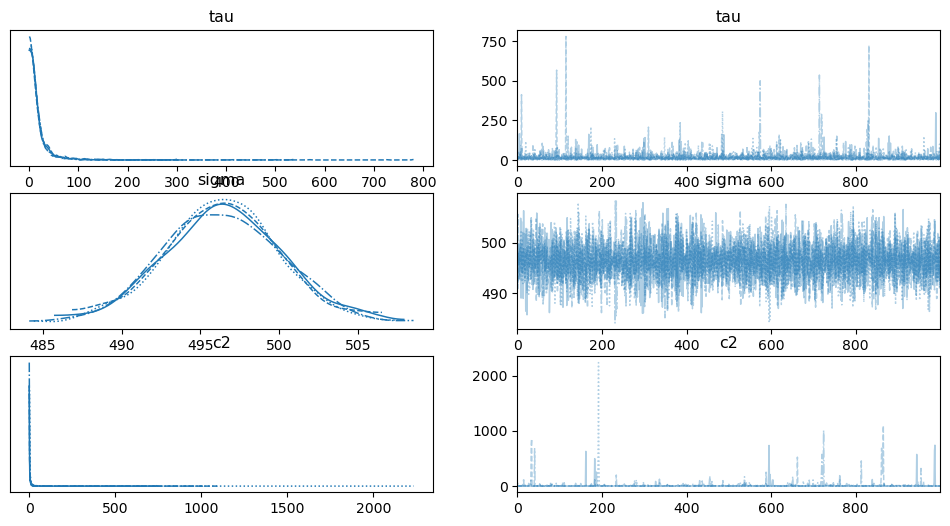

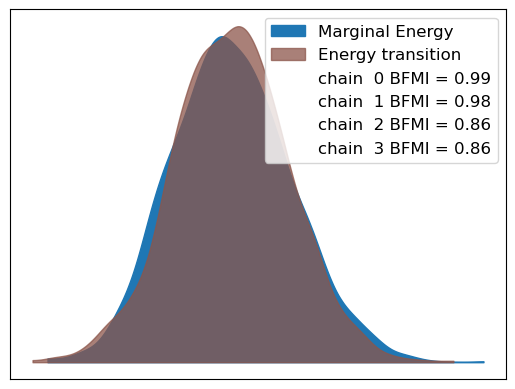

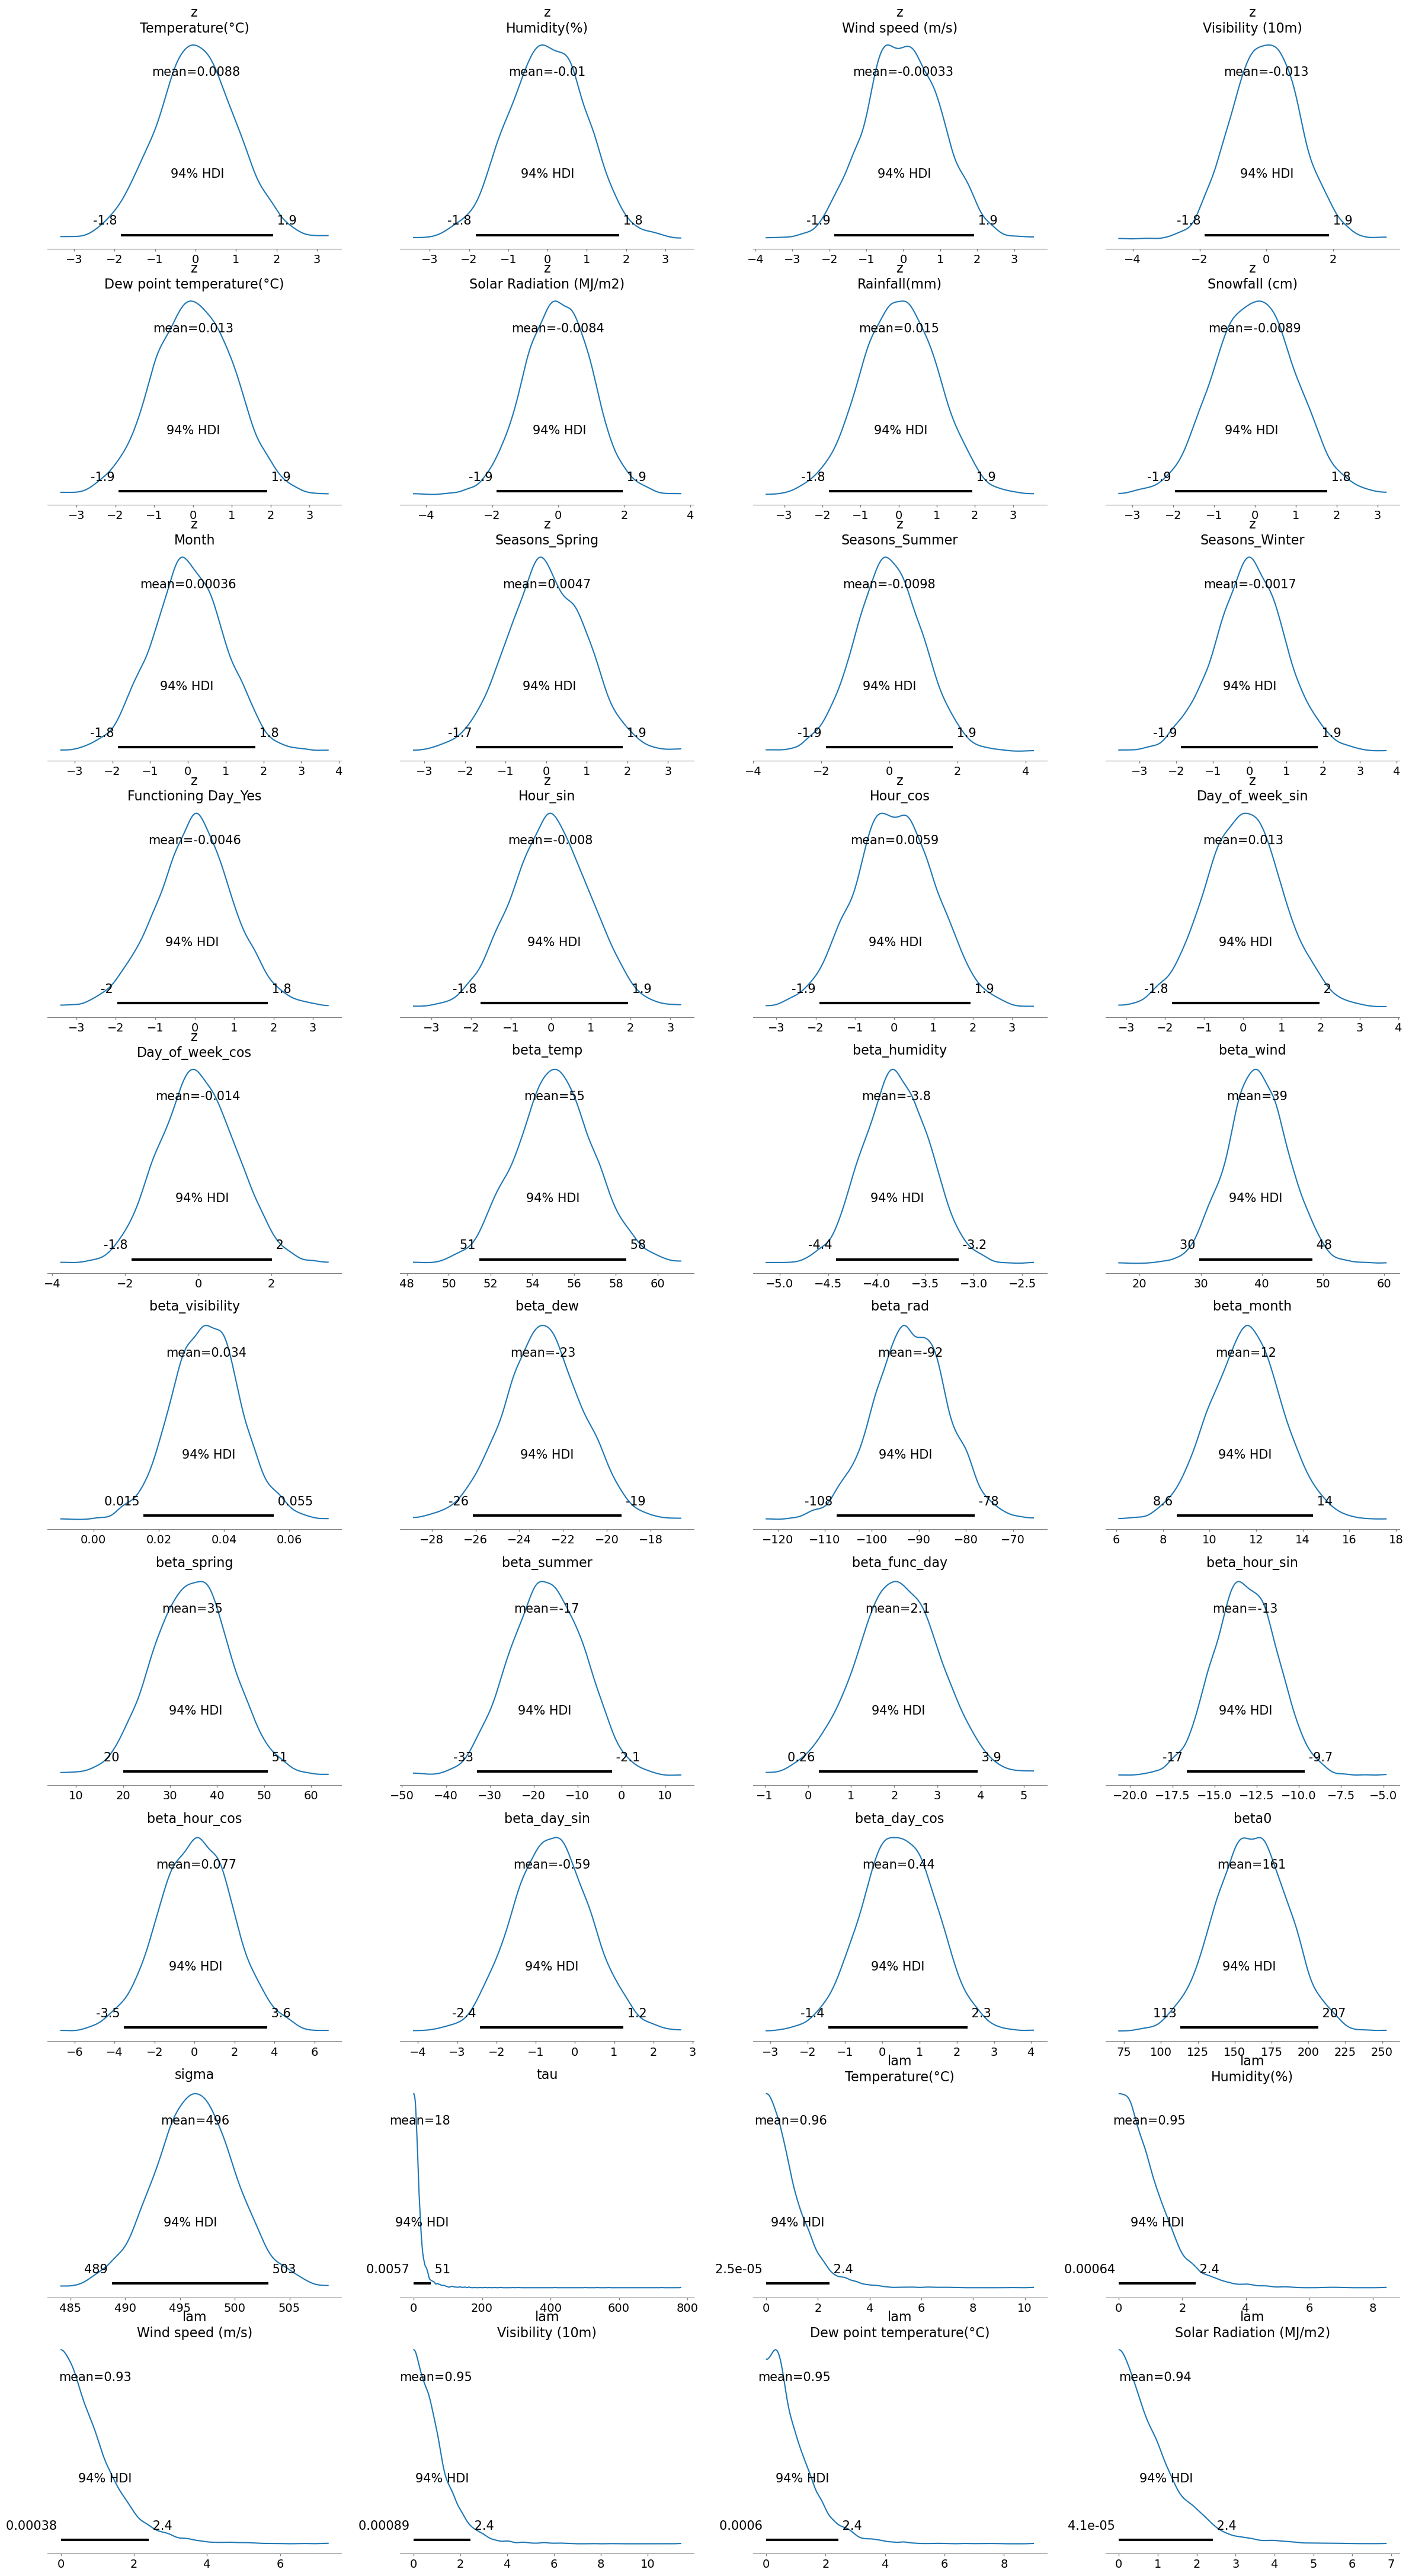

In [115]:

az.plot_trace(idata, var_names=["tau", "sigma", "c2"])
az.plot_energy(idata)
az.plot_posterior(idata)